# Working with PyEsper
Working with PyEsper package to emulate how the SAGE MATLAB GUI works for estimating correct nitrate values.

Reference Package: https://github.com/LarissaMDias/PyESPER
* PyESPER is a Python implementation of MATLAB Empirical Seawater Property Estimation Routines (ESPERs), and the present version consists of a preliminary Jupyter Notebook which implements these routines. These routines provide estimates of seawater biogeochemical properties at user-provided sets of coordinates, depth, and available biogeochemical properties. Three algorithm options are available through these routines: Locally interpolated regressions (LIRs), Neural networks (NNs) & Mixed.

**Wokring with float data: Float 7902199**


## Set up of Libraries

In [112]:
#Basic Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

#Importing Data
import netCDF4
import os

## Reading in the data file

In [5]:
#Getting current working directory for the path to the data file
cwd = os.getcwd()
cwd

'C:\\Users\\jojob\\NOAA Lapenta Code\\NO3_DMQC_Prep'

In [3]:
#reading in the data 
file2read = netCDF4.Dataset(cwd + r'\7902199_Sprof.nc', 'r')

#viewing all of the variables in the file
print(file2read.variables.keys())

dict_keys(['DATA_TYPE', 'FORMAT_VERSION', 'HANDBOOK_VERSION', 'REFERENCE_DATE_TIME', 'DATE_CREATION', 'DATE_UPDATE', 'PLATFORM_NUMBER', 'PROJECT_NAME', 'PI_NAME', 'STATION_PARAMETERS', 'CYCLE_NUMBER', 'DIRECTION', 'DATA_CENTRE', 'PARAMETER_DATA_MODE', 'PLATFORM_TYPE', 'FLOAT_SERIAL_NO', 'FIRMWARE_VERSION', 'WMO_INST_TYPE', 'JULD', 'JULD_QC', 'JULD_LOCATION', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'POSITIONING_SYSTEM', 'CONFIG_MISSION_NUMBER', 'PARAMETER', 'SCIENTIFIC_CALIB_EQUATION', 'SCIENTIFIC_CALIB_COEFFICIENT', 'SCIENTIFIC_CALIB_COMMENT', 'SCIENTIFIC_CALIB_DATE', 'PROFILE_PRES_QC', 'PROFILE_TEMP_QC', 'PROFILE_PSAL_QC', 'PROFILE_DOXY_QC', 'PROFILE_BBP700_QC', 'PROFILE_CHLA_QC', 'PROFILE_CDOM_QC', 'PROFILE_PH_IN_SITU_TOTAL_QC', 'PROFILE_NITRATE_QC', 'PRES', 'PRES_QC', 'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PRES_ADJUSTED_ERROR', 'TEMP', 'TEMP_QC', 'TEMP_dPRES', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'TEMP_ADJUSTED_ERROR', 'PSAL', 'PSAL_QC', 'PSAL_dPRES', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_

## Working with Profiles 
* PRES
* NITRATE
* JULD
* DOXY
* PSAL
* TEMP
* LONGITUDE
* LATITUDE

### Getting the Data

In [44]:
# Selecting a variables: NO3, JULD, PRES
#extracting a numpy array

#Nitrate
nitrate = file2read.variables['NITRATE'][:]  

#Julian Day
jul = file2read.variables['JULD'][:]

#Pressure
pres = file2read.variables['PRES'][:]

#TEMP
temp = file2read.variables['TEMP'][:]  

#PSAL
sal = file2read.variables['PSAL'][:]  

#DOXY
oxy = file2read.variables['DOXY'][:]  

#LONGITUDE
long = file2read.variables['LONGITUDE'][:]  

#LATITUDE
lat = file2read.variables['LATITUDE'][:]  


# Close dataset
#file2read.close()

## Adding Data Variables:
Code to get vars near 1500 dbar:

### Function for closest values INDIVIDUAL VARS

In [45]:
def closest_vals(variable, pres, jul, lat, long, threshold=30):
    """
    Returns an array with (julian_day, latitude, longitude, variable_value) at the pressure closest to 1500 dbar for each profile.

    Parameters:
    - variable: 2D array [profiles x depths] of the variable (e.g., nitrate)
    - pres: 2D array [profiles x depths] of pressure values
    - jul: 1D array of Julian days
    - lat: 1D array of latitudes
    - long: 1D array of longitudes
    - threshold: pressure range from 1500 dbar (default will be ±30 dbar)
    """
    closest_multi_vars = []
    
    for profile in range(variable.shape[0]):  #looping through the 39 profiles
        #grabbing the pressure & var data for the current interation of the profile
        pres_profile = pres[profile, :]  #selecting the whole row of pressure data
        variable_profile = variable[profile, :]  #selecting the whole row of var data
        
        #removing NaN vals from the var data
        valid_variable = ~np.isnan(variable_profile)
    
        #find pressure values near 1500 dbar within the 30 dbar threshold
        pressure_near_1500 = np.abs(pres_profile - 1500) <= threshold #using abs for all positive, calculates how far each pressure value is from 1500 
    
        #combine both into one mask
        valid_mask = valid_variable & pressure_near_1500
    
        if np.any(valid_mask):  # Ensure there are valid matches
            #finding the difference from 1500 dbar again collecting them in an array
            pressure_differences = np.abs(pres_profile[valid_mask] - 1500)
    
            #finds the index of the smallest value
            closest_idx = np.argmin(pressure_differences)
    
            #finding corresponding time and var vals to closest pres to 1500 dbar
            matched_var = variable_profile[valid_mask][closest_idx]
    
            #adding the closest vals to the closest dict
            closest_multi_vars.append((jul[profile], lat[profile], long[profile], matched_var))
    
    # Convert list to NumPy array
    closest_multi_array = np.array(closest_multi_vars)
    return closest_multi_array


### Temperature

In [46]:
temp_array = closest_vals(temp, pres, jul, lat, long, threshold=30)
temp_array.shape

(39, 4)

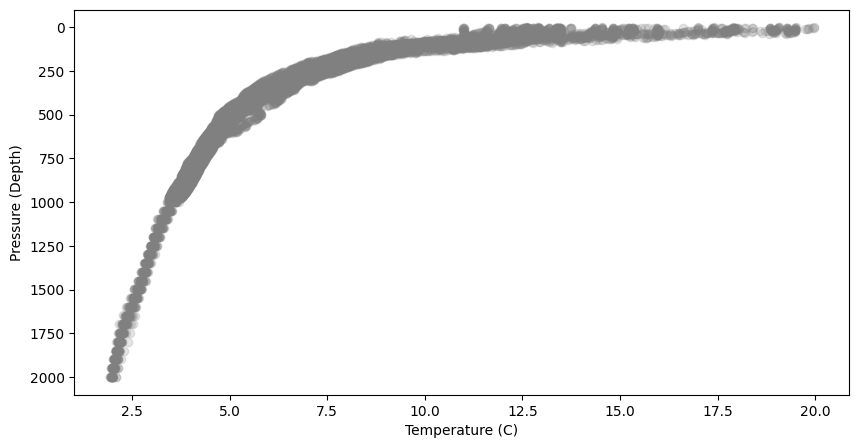

In [47]:
plt.figure(figsize=(10, 5))

# Section Plot: Temperarure vs. Pressure (Depth)
plt.scatter(temp, pres, c='grey', alpha=0.2)
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (Depth)')
plt.gca().invert_yaxis()  # Flip y-axis to show depth 
plt.show()

In [48]:
# Separate the columns into two variables
closest_time_temp = temp_array[:, 0]  #time values (jul days)
closest_lat_temp = temp_array[:, 1]  #lat values 
closest_long_temp = temp_array[:, 2]  #long values
closest_temp = temp_array[:, 3]  #temp values

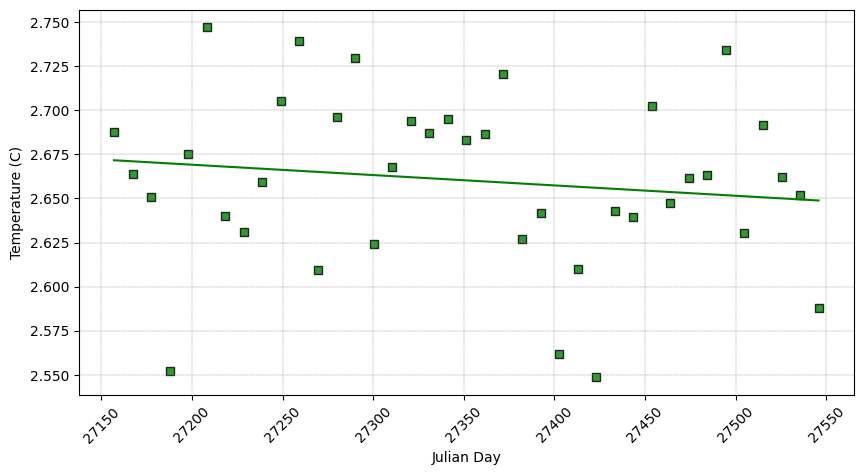

In [49]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
plt.scatter(closest_time_temp, closest_temp, marker='s', facecolors='green', edgecolors='black', alpha=.8)

#line of best fit
m, b = np.polyfit(closest_time_temp, closest_temp, 1)  
y_fit = m * closest_time_temp + b
plt.plot(closest_time_temp, y_fit, color='green')


plt.grid(True, color='gray', linewidth=0.3, linestyle='--')
plt.xlabel("Julian Day")
plt.ylabel("Temperature (C)")
plt.show()

### Salinity

In [50]:
sal_array = closest_vals(sal, pres, jul, lat, long, threshold=30)
sal_array.shape

(39, 4)

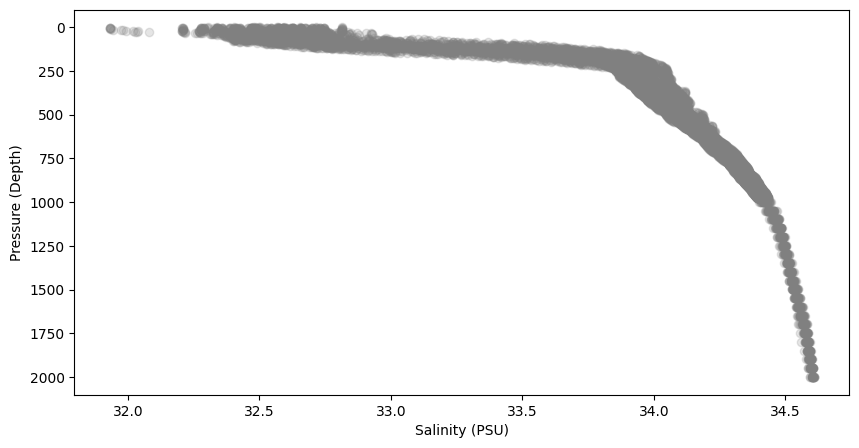

In [51]:
plt.figure(figsize=(10, 5))

# Section Plot: Temperarure vs. Pressure (Depth)
plt.scatter(sal, pres, c='grey', alpha=0.2)
plt.xlabel('Salinity (PSU)')
plt.ylabel('Pressure (Depth)')
plt.gca().invert_yaxis()  # Flip y-axis to show depth 
plt.show()

In [52]:
# Separate the columns into two variables
closest_time_sal = sal_array[:, 0]  #time values (jul days)
closest_lat_sal = sal_array[:, 1]  #lat values 
closest_long_sal = sal_array[:, 2]  #long values
closest_sal = sal_array[:, 3]  #sal values

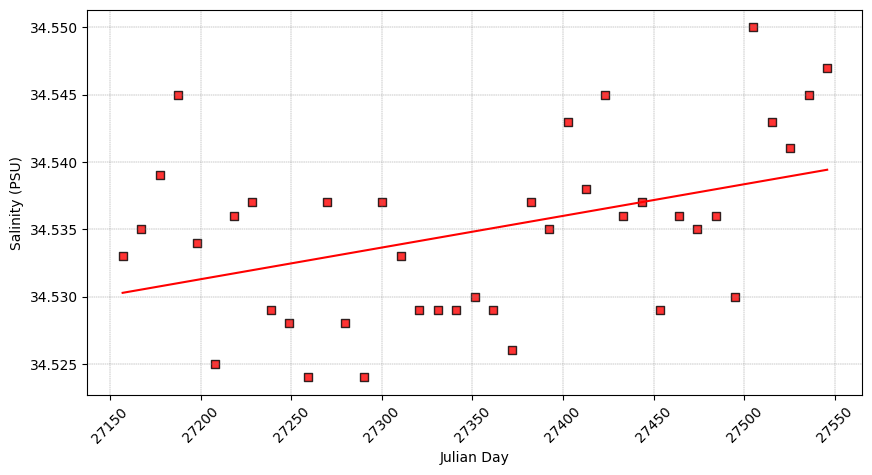

In [53]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
plt.scatter(closest_time_sal, closest_sal, marker='s', facecolors='red', edgecolors='black', alpha=.8)

#line of best fit
m, b = np.polyfit(closest_time_sal, closest_sal, 1)  
y_fit = m * closest_time_sal + b
plt.plot(closest_time_sal, y_fit, color='red')


plt.grid(True, color='gray', linewidth=0.3, linestyle='--')
plt.xlabel("Julian Day")
plt.ylabel("Salinity (PSU)")
plt.show()

### Dissolved Oxygen

In [54]:
oxy_array = closest_vals(oxy, pres, jul, lat, long, threshold=30)
oxy_array.shape

(39, 4)

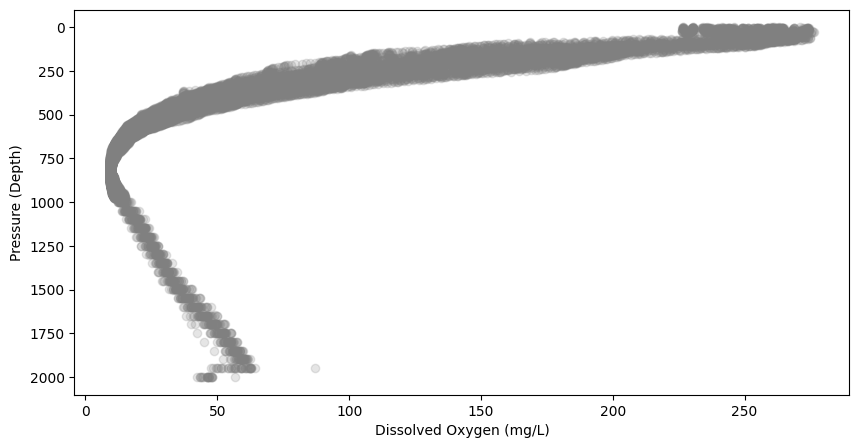

In [55]:
plt.figure(figsize=(10, 5))

# Section Plot: Temperarure vs. Pressure (Depth)
plt.scatter(oxy, pres, c='grey', alpha=0.2)
plt.xlabel('Dissolved Oxygen (mg/L)')
plt.ylabel('Pressure (Depth)')
plt.gca().invert_yaxis()  # Flip y-axis to show depth 
plt.show()

In [56]:
# Separate the columns into two variables
closest_time_oxy = oxy_array[:, 0]  #time values (jul days)
closest_lat_oxy = oxy_array[:, 1]  #lat values 
closest_long_oxy = oxy_array[:, 2]  #long values
closest_oxy = oxy_array[:, 3]  #oxy values

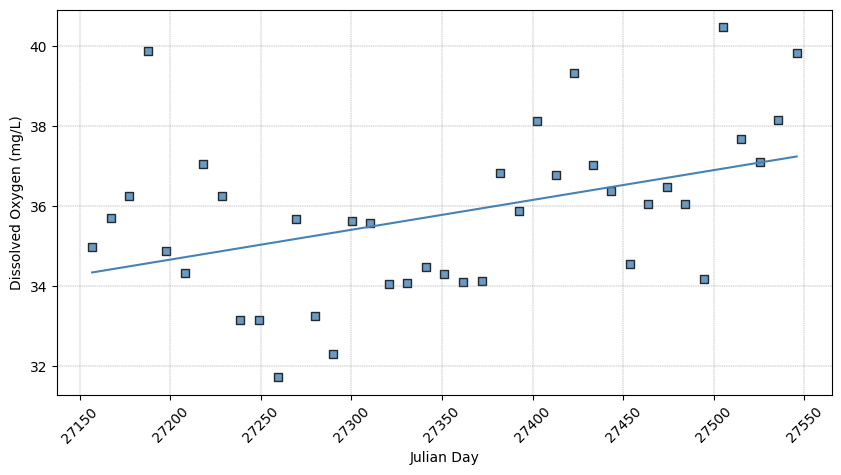

In [57]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
plt.scatter(closest_time_oxy, closest_oxy, marker='s', facecolors='steelblue', edgecolors='black', alpha=.8)

#line of best fit
m, b = np.polyfit(closest_time_oxy, closest_oxy, 1)  
y_fit = m * closest_time_oxy + b
plt.plot(closest_time_oxy, y_fit, color='steelblue')


plt.grid(True, color='gray', linewidth=0.3, linestyle='--')
plt.xlabel("Julian Day")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.show()

## Function for closest values COMBINED VARS

In [113]:
def closest_vals_multi(variable, pres, jul, lat, long, temp, sal, wanted_depth=1500, threshold=30):
    """
    Returns an array with (julian_day, latitude, longitude, temp, sal, variable_value)
    at the pressure closest to 1500 dbar for each profile.
    """
    closest_multi_vars = []
    
    for profile in range(variable.shape[0]):  #looping through the 39 profiles
        #grabbing the pressure & var data for the current interation of the profile
        pres_profile = pres[profile, :]  #selecting the whole row of pressure data
        variable_profile = variable[profile, :]  #selecting the whole row of var data
        
        #removing NaN vals from the var data
        valid_variable = ~np.isnan(variable_profile)
    
        #find pressure values near 1500 dbar within the 30 dbar threshold
        pressure_near_1500 = np.abs(pres_profile - wanted_depth) <= threshold #using abs for all positive, calculates how far each pressure value is from 1500 
    
        #combine both into one mask
        valid_mask = valid_variable & pressure_near_1500

        if np.any(valid_mask):  # Ensure there are valid matches
            #finding the difference from 1500 dbar again collecting them in an array
            pressure_differences = np.abs(pres_profile[valid_mask] - wanted_depth)
    
            #finds the index of the smallest value
            closest_idx = np.argmin(pressure_differences)
    
            #finding corresponding time and var vals to closest pres to 1500 dbar
            # Get matching index for temp and sal
            valid_indices = np.where(valid_mask)[0]  
            depth_idx = valid_indices[closest_idx]   #finding matching depth index
            
            #getting matching temp and sal
            matched_var = float(variable_profile[depth_idx])
            matched_temp = float(temp[profile, depth_idx])
            matched_sal = float(sal[profile, depth_idx])
            matched_pres = float(pres[profile, depth_idx])
            
            # pulling year from julian day
            date = base_date + datetime.timedelta(days=float(jul[profile]))
            year = date.year
            
            #adding the closest vals to the closest dict
            closest_multi_vars.append((
                year,
                float(jul[profile]),
                float(lat[profile]),
                float(long[profile]),
                matched_pres,
                matched_temp,
                matched_sal,
                matched_var
            ))

    # Convert list to NumPy array
    closest_multi_array = np.array(closest_multi_vars)
    return closest_multi_array


### Running the function

In [114]:
closest_vals_array_multi = closest_vals_multi(oxy, pres, jul, lat, long, temp, sal, wanted_depth=1500, threshold=30)
closest_vals_array_multi.shape

(39, 8)

### Saving the data into an array file

In [115]:
np.save("closest_vals_multi.npy", closest_vals_array_multi)

## Loading in the data as a data frame

In [110]:
closest_vals_array = np.load("closest_vals_multi.npy")

columns = ["year", "latitude", "longitude", "depth", "temperature", "salinity", "oxygen"]
float_data = pd.DataFrame(closest_vals_array, columns=columns)
float_data

,year,latitude,longitude,depth,temperature,salinity,oxygen
0,2024.0,40.0458,-127.2058,1499.099976,2.6878,34.533001,34.974499
1,2024.0,40.1799,-127.3111,1499.400024,2.6641,34.535000,35.703800
2,2024.0,40.0757,-127.6505,1499.599976,2.6506,34.539001,36.266499
3,2024.0,40.0140,-127.9516,1499.699951,2.5522,34.544998,39.888302
4,2024.0,40.0748,-127.9755,1499.699951,2.6753,34.534000,34.885601
5,2024.0,40.5038,-128.2424,1499.699951,2.7470,34.525002,34.329601
6,2024.0,40.7113,-128.9726,1499.300049,2.6399,34.535999,37.066898
7,2024.0,40.6399,-129.0745,1500.099976,2.6309,34.536999,36.258598
8,2024.0,40.5610,-129.0913,1498.800049,2.6592,34.528999,33.155201
9,2024.0,40.4563,-129.0215,1498.900024,2.7050,34.528000,33.156200


## Working with PyEsper with float_data

In [ ]:
# %% EXAMPLE
from PyESPER.lir import lir
from PyESPER.nn import nn
import pandas as pd
import numpy as np

data = pd.DataFrame(closest_vals_array, columns=columns)

PredictorMeasurements = {
    'salinity': data["salinity"].tolist(),
    'temperature': data["temperature"].tolist(),
    'oxygen': data["oxygen"].tolist()
}

OutputCoordinates = {
    'longitude': data["longitude"].tolist(),
    'latitude': data["latitude"].tolist(),
    'depth': data["depth"].tolist()
}

MeasUncerts = {
    'sal_u': [0.001], 
    'temp_u': [0.3], 
    'oxygen_u': [0.025]
}

EstDates = data["year"].tolist()
Path = "./" # path works relative to the location of this script

EstimatesLIR, CoefficientsLIR, UncertaintiesLIR = lir(
    ['nitrate'], 
    Path, 
    OutputCoordinates, 
    PredictorMeasurements, 
    EstDates=EstDates, 
    Equations=[7])

print('Estimated nitrate:')
EstimatesLIR['nitrate7']
